# Imports

In [1]:
import os
import sys
import json
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# go up until we are in the project base directory
base_dir = os.getcwd()
while base_dir.split('/')[-1] != 'provide':
    base_dir = os.path.normpath(os.path.join(base_dir, '..'))

# add paths for tools and data
things_to_add = ['general_tools', 'aggregation_tools', 'general_data_for_aggregation']
for thing in things_to_add:
    sys.path.append(os.path.join(base_dir, thing))

# import stuff we need
from general_tools import check_if_notebook, mkdir
from oggm_result_filepath_and_realisations import (gcms_mesmer, quantiles_mesmer,
    scenarios_mesmer, oggm_result_dir, provide_regions, raw_oggm_output_file)
from aggregation_preprocessing import open_grid_from_dict
from actual_aggregation import open_files_and_aggregate_on_map, aggregating_scenario, check_slurm_done

In [3]:
# Use this to conditionally execute tests/debugging
if check_if_notebook():
    is_notebook = True
else:
    is_notebook = False

# Define directories

In [4]:
resolution_dir = 'total_data'

In [5]:
preprocess_region_dict_outpath = os.path.join(base_dir, 'glacier_regions', resolution_dir)
mkdir(preprocess_region_dict_outpath);

# Open data

In [6]:
with open(os.path.join(preprocess_region_dict_outpath, "preprocessed_region_grids.json"), 'r') as f:
    region_structure_dict = json.load(f)

# Code for testing functionalities in notebook

## select test country

In [7]:
if is_notebook:
    test_region_name = 'east_asia'
    region_notebook = open_grid_from_dict(region_structure_dict[test_region_name])

## test smoothing and glacier size threshold

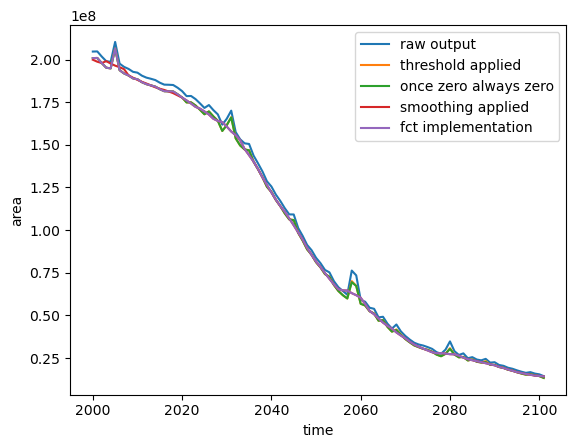

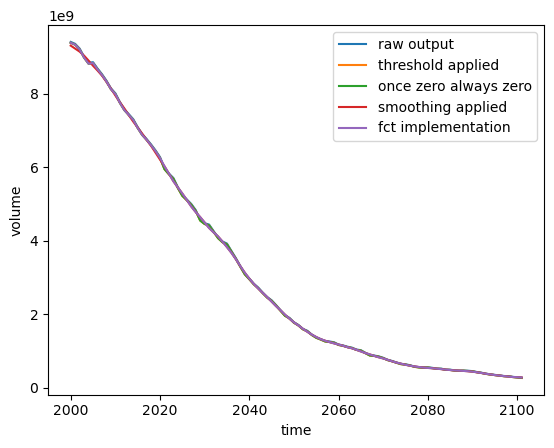

In [8]:
if is_notebook:
    from actual_aggregation import (get_all_files_from_result_batches,
        apply_size_threshold_and_smoothing)
    # get all files for this country, only keep the once from current scenario
    all_files_region = get_all_files_from_result_batches(
        oggm_result_dir,
        raw_oggm_output_file,
        list(region_notebook.result_batches.keys()))

    with xr.open_dataset(all_files_region[0]) as ds:
        ds_example = ds[['volume', 'area']]

    ds_adapted_2 = ds_example.copy()

    # define thersholds
    area_threshold = 0.01 * 1e6  # m²
    # VAS following Marzeion et. al., 2012
    volume_threshold = 0.1912 * area_threshold ** 1.375  # m³

    # use thershold
    ds_adapted_2['volume'] = ds_adapted_2['volume'] - volume_threshold
    ds_adapted_2['area'] = ds_adapted_2['area'] - area_threshold
    below_threshold_mask = (ds_adapted_2.volume < 0) | (ds_adapted_2.area < 0)
    ds_adapted_2['volume'] = xr.where(below_threshold_mask, 0, ds_adapted_2['volume'])
    ds_adapted_2['area'] = xr.where(below_threshold_mask, 0, ds_adapted_2['area'])

    # set everything to zero once a zero occured
    ds_adapted_4 = ds_adapted_2.copy()
    non_zero = ds_adapted_4['volume'] != 0
    mask = non_zero.cumprod('time')
    ds_adapted_4[['volume', 'area']] = ds_adapted_4[['volume', 'area']] * mask
    #ds_adapted_4['volume'] = ds_adapted_4['volume'] * mask
    #ds_adapted_4['area'] = ds_adapted_4['area'] * mask

    # rolling mean
    ds_adapted_3 = ds_adapted_4.copy()
    ds_adapted_3[['area', 'volume']] = ds_adapted_3[['area', 'volume']].rolling(
        min_periods=1, time=5, center=True).mean()

    # area plot
    ds_example.sum(dim='rgi_id').area.plot(label='raw output')
    ds_adapted_2.sum(dim='rgi_id').area.plot(label='threshold applied')
    ds_adapted_4.sum(dim='rgi_id').area.plot(label='once zero always zero')
    ds_adapted_3.sum(dim='rgi_id').area.plot(label='smoothing applied')
    apply_size_threshold_and_smoothing(ds_example.copy()).sum(dim='rgi_id').area.plot(label='fct implementation')
    plt.legend()
    plt.show()

    # volume plot
    ds_example.sum(dim='rgi_id').volume.plot(label='raw output')
    ds_adapted_2.sum(dim='rgi_id').volume.plot(label='threshold applied')
    ds_adapted_4.sum(dim='rgi_id').volume.plot(label='once zero always zero')
    ds_adapted_3.sum(dim='rgi_id').volume.plot(label='smoothing applied')
    apply_size_threshold_and_smoothing(ds_example.copy()).sum(dim='rgi_id').volume.plot(label='fct implementation')
    plt.legend()
    plt.show()

## test aggregation

In [9]:
if is_notebook:
    for test_scenario in scenarios_mesmer[:1]:
        open_files_and_aggregate_on_map(
            target_name=test_region_name,
            target_structure_dict=region_structure_dict,
            scenario=test_scenario,
            output_folder='aggregated_data_test',
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=None,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            time_steps=np.arange(2015, 2101, 5),
            gcm_test=gcms_mesmer[:1],
            quantile_test=quantiles_mesmer,
            reset_files=True,
            add_map_data=True,
            use_mfdataset=False,
        )

Starting openening and aggregation on map for east_asia and CurPol
Opening CurPol, ACCESS-ESM1-5, 0.05 (0.1 s)
Processing file: 0/5
Processing file: 1/5
Processing file: 2/5
Processing file: 3/5
Processing file: 4/5
Saving aggregated map data
Saving aggregated total data
Opening CurPol, ACCESS-ESM1-5, 0.25 (1.3 s)
Processing file: 0/5
Processing file: 1/5
Processing file: 2/5
Processing file: 3/5
Processing file: 4/5
Saving aggregated map data
Saving aggregated total data
Opening CurPol, ACCESS-ESM1-5, 0.5 (2.2 s)
Processing file: 0/5
Processing file: 1/5
Processing file: 2/5
Processing file: 3/5
Processing file: 4/5
Saving aggregated map data
Saving aggregated total data
Opening CurPol, ACCESS-ESM1-5, 0.75 (3.2 s)
Processing file: 0/5
Processing file: 1/5
Processing file: 2/5
Processing file: 3/5
Processing file: 4/5
Saving aggregated map data
Saving aggregated total data
Opening CurPol, ACCESS-ESM1-5, 0.95 (4.1 s)
Processing file: 0/5
Processing file: 1/5
Processing file: 2/5
Process

In [13]:
if is_notebook:
    for test_scenario in scenarios_mesmer[:2]:
        aggregating_scenario(
            target_name=test_region_name,
            target_structure_dict=region_structure_dict,
            scenario=test_scenario,
            output_folder='aggregated_data_test',
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=None,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            risk_variables=['volume', 'area'],
            risk_thresholds=np.append(np.arange(10, 91, 10), [99]),  # in % melted of 2020, 10% means 10% of 2020 melted
            time_steps=np.arange(2015, 2101, 5),
            gcm_test=gcms_mesmer[:2],
            quantile_test=quantiles_mesmer,
            reset_files=True,
            add_map_data=False,
        )

Starting aggregation scenario for east_asia and CurPol
Finished opening target files, start calculation of weighted quantiles (0.3 s)
Start saving
Finished calculation of weighted quantiles for timeseries (0.6 s)
Finished opening risk files, start calculation of risk (0.9 s)
Finished calculation of weighted quantiles for risk (2.3 s)
Finished aggregation scenario for east_asia and CurPol
Starting aggregation scenario for east_asia and GS
Finished opening target files, start calculation of weighted quantiles (0.2 s)
Start saving
Finished calculation of weighted quantiles for timeseries (0.6 s)
Finished opening risk files, start calculation of risk (0.8 s)
Finished calculation of weighted quantiles for risk (2.1 s)
Finished aggregation scenario for east_asia and GS


## look at notebook test results

### map

In [5]:
if is_notebook:
    raise NotImplementedError
    from aggregation_plots import plot_map

    # open shapefile of country for plot
    countries_data_dir = os.path.join(base_dir, 'countries', 'data')
    countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
    gdf_countries = gpd.read_file(os.path.join(countries_data_dir, countries_file))
    name_col_countries = 'ADM0_A3_DE'
    country = gdf_countries[gdf_countries[name_col_countries] == test_country_name]
    
    plot_map(target=country,
             target_name=test_country_name,
             scenario=scenarios_mesmer[0],
             input_dir='aggregated_data_test',
            )

NotImplementedError: 

### total region

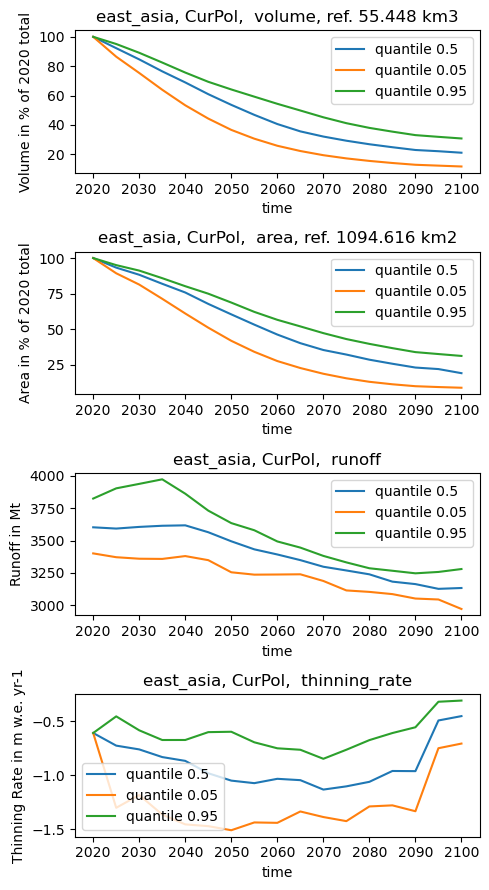

In [14]:
if is_notebook:
    from aggregation_plots import plot_timeseries
    
    plot_timeseries(target_name=test_region_name,
                    scenario=scenarios_mesmer[0],
                    input_dir='aggregated_data_test'
                   )

### risk plot

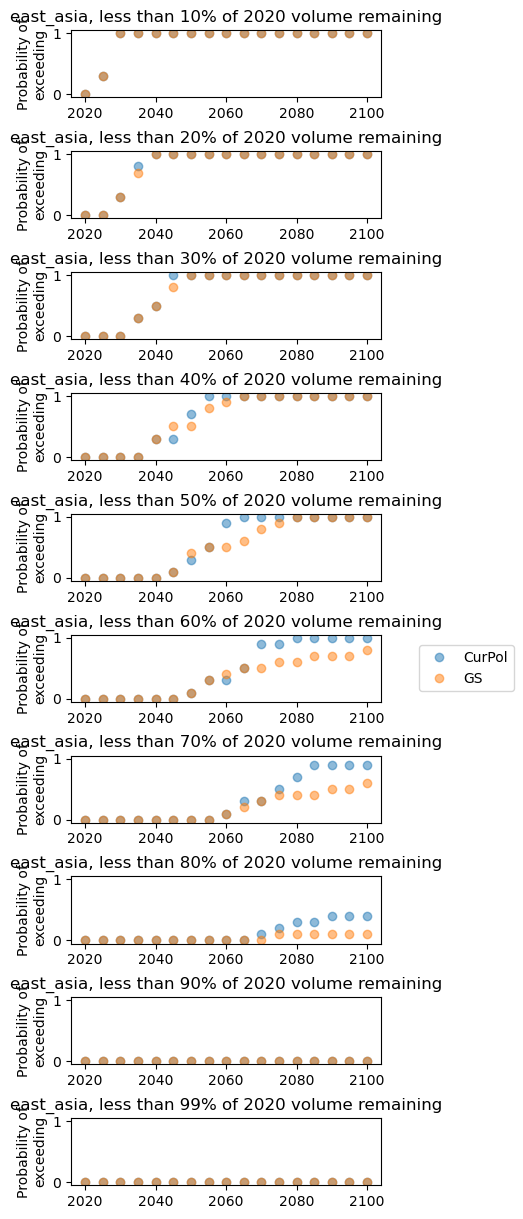

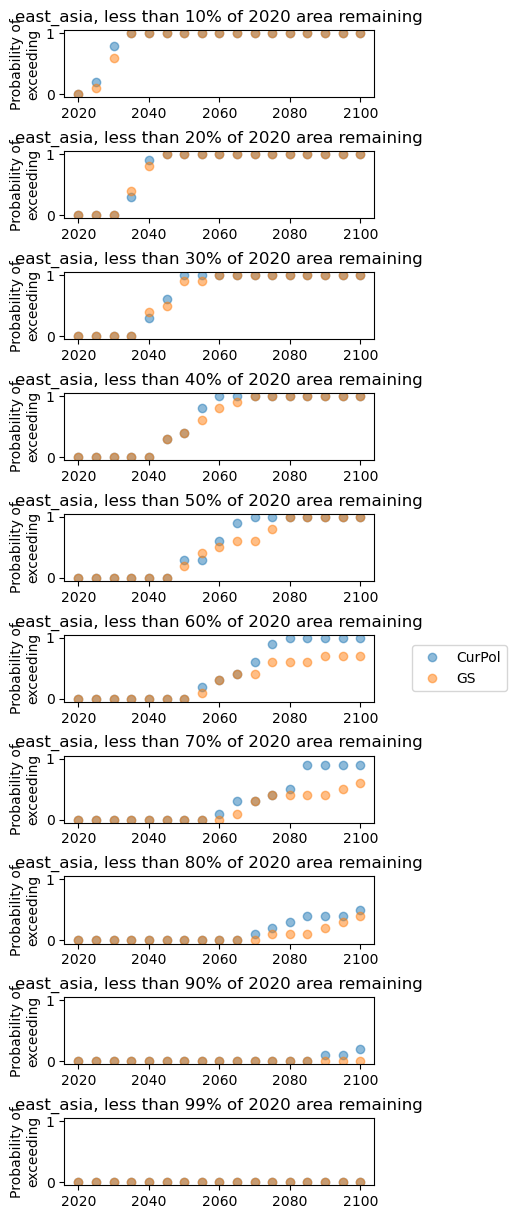

In [15]:
if is_notebook:
    from aggregation_plots import plot_unavoidable_risk
    
    plot_unavoidable_risk(target_name=test_region_name,
                           scenarios=scenarios_mesmer[:2],
                           input_dir='aggregated_data_test')

# Code for running on cluster

## define experiments for multiprocessing

In [16]:
# create dict for sbatch --array=
slurm_arrays = {}

count = 1
for region in region_structure_dict.keys():
    for scenario in scenarios_mesmer:
        slurm_arrays[str(count)] = (region, scenario)
        count += 1

if is_notebook:
    print(slurm_arrays)

{'1': ('arctic_canada', 'CurPol'), '2': ('arctic_canada', 'GS'), '3': ('arctic_canada', 'LD'), '4': ('arctic_canada', 'ModAct'), '5': ('arctic_canada', 'Ref'), '6': ('arctic_canada', 'Ren'), '7': ('arctic_canada', 'Neg'), '8': ('arctic_canada', 'SP'), '9': ('arctic_canada', 'ssp119'), '10': ('arctic_canada', 'ssp534-over'), '11': ('caucasus_and_middle_east', 'CurPol'), '12': ('caucasus_and_middle_east', 'GS'), '13': ('caucasus_and_middle_east', 'LD'), '14': ('caucasus_and_middle_east', 'ModAct'), '15': ('caucasus_and_middle_east', 'Ref'), '16': ('caucasus_and_middle_east', 'Ren'), '17': ('caucasus_and_middle_east', 'Neg'), '18': ('caucasus_and_middle_east', 'SP'), '19': ('caucasus_and_middle_east', 'ssp119'), '20': ('caucasus_and_middle_east', 'ssp534-over'), '21': ('central_asia', 'CurPol'), '22': ('central_asia', 'GS'), '23': ('central_asia', 'LD'), '24': ('central_asia', 'ModAct'), '25': ('central_asia', 'Ref'), '26': ('central_asia', 'Ren'), '27': ('central_asia', 'Neg'), '28': ('c

## run current experiment

In [158]:
if not is_notebook:
    slurm_id = os.environ.get('ARRAY_ID', None)
    # convert slurm array to region and scenario
    region, scenario = slurm_arrays[slurm_id]

    # save results on cluster and copy at the end in run_slurm-file
    working_dir_cluster = os.environ.get('OGGM_WORKDIR', None)

    aggregated_data_outpath = os.path.join(
        working_dir_cluster, 'aggregated_data')
    mkdir(aggregated_data_outpath);

    aggregated_data_intermediate_outpath = os.path.join(
        working_dir_cluster, 'aggregated_data_intermediate')
    mkdir(aggregated_data_intermediate_outpath);

    open_files_and_aggregate_on_map(
            target_name=region,
            target_structure_dict=region_structure_dict,
            scenario=scenario,
            output_folder=aggregated_data_outpath,
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=aggregated_data_intermediate_outpath,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            #risk_variables=['volume', 'area'],
            #risk_thresholds=np.append(np.arange(10, 91, 10), [99]),  # in % melted of 2020, 10% means 10% of 2020 melted
            time_steps=np.arange(2015, 2101, 5),
            reset_files=False,
            add_map_data=True,
            use_mfdataset=False,  # can be used for regions where OOM errors occure
        )

## check which experiments failed for rerunning

In [18]:
if is_notebook:
    check_slurm_done(461853)

Files without 'SLURM DONE':
sbatch --array=29,27,30,26,21,28,22,25,24,23 run_slurm_aggregation_workflow.sh


In [15]:
if is_notebook:
    check_slurm_done(465054)

All files contain 'SLURM DONE'.
